## Introduction
In this lab, you'll create two clustering models (DBSCAN and HDBSCAN) using data curated by StatCan containing the names, types, and locations of
cultural and art facilities across Canada.
We'll focus on the museum locations provided across Canada.

#### Data source: The Open Database of Cultural and Art Facilities (ODCAF)

A collection of open data containing the names, types, and locations of cultural and art facilities across Canada. 
It is released under the Open Government License - Canada.
The different types of facilities are labeled under 'ODCAF_Facility_Type'.

#### Landing page:
https://www.statcan.gc.ca/en/lode/databases/odcaf

#### link to zip file:
https://www150.statcan.gc.ca/n1/en/pub/21-26-0001/2020001/ODCAF_V1.0.zip?st=brOCT3Ry

## Flow
- Import libraries
- Download map
- Create visualization function
- Preprocess data
- Cluster model development and prediction
- Visualization

### Import libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import hdbscan

# Geographical tools
import geopandas as gpd  # pandas dataframe-like geodataframes for geographical data
import contextily as ctx  # used for obtianing a basemap of Canada
from shapely.geometry import Point

### Download map

In [21]:
import requests
import zipfile
import io
import os

# URL of the ZIP file on the cloud server
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'

# Directory to save the extracted TIFF file
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Download the ZIP file
response = requests.get(zip_file_url)
response.raise_for_status()  # Ensure the request was successful
# Step 2: Open the ZIP file in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    # Step 3: Iterate over the files in the ZIP
    for file_name in zip_ref.namelist():
        if file_name.endswith('.tif'):  # Check if it's a TIFF file
            # Step 4: Extract the TIFF file
            zip_ref.extract(file_name, output_dir)
            print(f"Downloaded and extracted: {file_name}")

Downloaded and extracted: Canada.tif


### Create visualization function

In [22]:
# Write a function that plots clustered locations and overlays them on a basemap.

def plot_clustered_locations(df,  title='Museums Clustered by Proximity'):
    """
    Plots clustered locations and overlays on a basemap.
    
    Parameters:
    - df: DataFrame containing 'Latitude', 'Longitude', and 'Cluster' columns
    - title: str, title of the plot
    """
    
    # Load the coordinates intto a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")
    
    # Reproject to Web Mercator to align with basemap 
    gdf = gdf.to_crs(epsg=3857)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Separate non-noise, or clustered points from noise, or unclustered points
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]
    
    # Plot noise points 
    noise.plot(ax=ax, color='k', markersize=3, ec='r', alpha=1, label='Noise')
    
    # Plot clustered points, colured by 'Cluster' number
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=False, alpha=0.6)
    
    # Add basemap of  Canada
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)
    
    # Format plot
    plt.title(title, )
    plt.xlabel('Longitude', )
    plt.ylabel('Latitude', )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    
    # Show the plot
    plt.show()

### Preprocess data
- Read the file
- Subset museum type for modeling
- Subset latitude and longitude for modeling feature
- Remove missing data
- Convernt latitude and longitude into float
- Normalize the data

In [23]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")
df.head(10)  # The missing value is marked as ..

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude
0,1,#Hashtag Gallery,..,gallery,toronto,..,801,dundas st w,M6J 1V2,toronto,on,801 dundas st w,Toronto,3520005,35,43.65169472,-79.40803272
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017
3,4,10 Austin Street,built heritage properties,heritage or historic site,moncton,..,10,austin st,E1C 1Z6,moncton,nb,10 austin st,Moncton,1307022,13,46.09247776,-64.78022946
4,5,10 Gates Dancing Inc.,arts,miscellaneous,ottawa,..,..,..,..,ottawa,on,..,Ottawa,3506008,35,45.40856224,-75.71536766
5,6,100 Mile House Branch,cariboo regional district library system,library or archives,government of british columbia,..,449,birch avenue s,V0K 2E0,pender island,bc,449 s. birch avenue,One Hundred Mile House,5941005,59,51.64139,-121.29562
6,8,114 Alma St.,built heritage properties,heritage or historic site,moncton,..,114,alma st,..,moncton,nb,114 alma st,Moncton,1307022,13,46.09186844,-64.77860387
7,9,118 Mountain Road,built heritage properties,heritage or historic site,moncton,..,118,mountain rd,E1C 2K7,moncton,nb,118 mountain rd,Moncton,1307022,13,46.09448386,-64.77990581
8,10,12 Service Battalion Museum,military museum or fort,museum,canadian museums association,..,5500,no 4 rd,V6X 3L5,richmond,bc,5500 no. 4 rd the sherman armoury richmond bri...,Richmond,5915015,59,49.1763542,-123.112783
9,11,134 Church Street,built heritage properties,heritage or historic site,moncton,..,134,church st,E1C 4Z6,moncton,nb,134 church st,Moncton,1307022,13,46.09253232,-64.77997633


In [24]:
df['ODCAF_Facility_Type'].value_counts()

ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

In [25]:
# Only take out museum facility type for modeling
df_museum = df[df['ODCAF_Facility_Type'] == 'museum']
df_museum

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017
8,10,12 Service Battalion Museum,military museum or fort,museum,canadian museums association,..,5500,no 4 rd,V6X 3L5,richmond,bc,5500 no. 4 rd the sherman armoury richmond bri...,Richmond,5915015,59,49.1763542,-123.112783
13,15,15th Field Artillery Regiment Museum And Archives,museum/gallery,museum,vancouver,..,2025,11th av w,V6J 2C7,vancouver,bc,2025 w 11th av vancouver bc v6j 2c7,Vancouver,5915022,59,49.261938,-123.151123
15,18,17 Wing Heritage Collection,aeronautics and space museum transportation mu...,museum,canadian museums association,..,..,..,R3J 3Y5,winnipeg,mb,air heritage park air force way winnipeg manit...,Winnipeg,4611040,46,49.88955855,-97.23574396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7940,9765,York Region District School Board Museum & Arc...,library and/or archives community/regional museum,museum,canadian museums association,..,21,renfrew dr,L3R 8H3,markham,on,21 renfrew dr markham ontario l3r 8h3 canada,Markham,3519036,35,43.857692,-79.3619396
7954,9779,Youthlink Calgary-The Calgary Police Interpret...,community/regional museum exhibition or cultur...,museum,canadian museums association,..,5111,47th street ne,T3J 3R2,calgary,ab,5111-47th street ne lc594 calgary alberta t3j ...,Calgary,4806016,48,..,..
7958,9783,Yukon Beringia Interpretive Centre,human history-archaelogy-anthropology or ethno...,museum,canadian museums association,..,1423,alaska hwy,Y1A 2C6,whitehorse,yt,kilometre 1423 (mile 886) alaska hwy po box 27...,Whitehorse,6001009,60,..,..
7968,9797,Craigdarroch Castle,museums and galleries,museum,victoria,..,..,..,..,victoria,bc,..,Victoria,5917034,59,48.42241956,-123.3435527


In [26]:
# To do DBSCAN and HDBSCAN modeling, we need features to calculate distance. In this case, we need latitude and longitude
df_museum = df_museum[['Latitude', 'Longitude']]
df_museum

,Latitude,Longitude
1,55.2645508,-127.6428124
2,45.963283,-66.6419017
8,49.1763542,-123.112783
13,49.261938,-123.151123
15,49.88955855,-97.23574396
...,...,...
7940,43.857692,-79.3619396
7954,..,..
7958,..,..
7968,48.42241956,-123.3435527


In [27]:
df_museum.info()  # Latitude and longitude are object data type. Need to convert them into float
df_museum

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1938 non-null   object
 1   Longitude  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


,Latitude,Longitude
1,55.2645508,-127.6428124
2,45.963283,-66.6419017
8,49.1763542,-123.112783
13,49.261938,-123.151123
15,49.88955855,-97.23574396
...,...,...
7940,43.857692,-79.3619396
7954,..,..
7958,..,..
7968,48.42241956,-123.3435527


In [28]:
# Remove the missing value first
df_museum = df_museum[(df_museum['Latitude'] != '..') & (df_museum['Longitude'] != '..')]
df_museum

,Latitude,Longitude
1,55.2645508,-127.6428124
2,45.963283,-66.6419017
8,49.1763542,-123.112783
13,49.261938,-123.151123
15,49.88955855,-97.23574396
...,...,...
7934,43.18308983,-79.2245641
7936,43.6900216,-79.476208
7940,43.857692,-79.3619396
7968,48.42241956,-123.3435527


In [29]:
df_museum[['Latitude', 'Longitude']] = df_museum[['Latitude', 'Longitude']].astype('float')
df_museum.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1607 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   1607 non-null   float64
 1   Longitude  1607 non-null   float64
dtypes: float64(2)
memory usage: 37.7 KB


C:\Users\nanya\AppData\Local\Temp\ipykernel_20080\72743392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_museum[['Latitude', 'Longitude']] = df_museum[['Latitude', 'Longitude']].astype('float')


In [33]:
# Since we will use latitude and longitude to calculate the distance, different range have big impact to the result
# Latitude is between +/- 90 and longitude is between 0 and 360
# Need to normalize the data --> make latitude * 2 (do not use StandardScaler since we only use part of the map)
df_model = df_museum.copy()
df_model['Latitude'] = df_museum['Latitude'] * 2
df_model

,Latitude,Longitude
1,110.529102,-127.642812
2,91.926566,-66.641902
8,98.352708,-123.112783
13,98.523876,-123.151123
15,99.779117,-97.235744
...,...,...
7934,86.366180,-79.224564
7936,87.380043,-79.476208
7940,87.715384,-79.361940
7968,96.844839,-123.343553


### Cluster model development and prediction
- DBSCAN model and prediction
- HDBSCAN model adn prediction

#### DBSCAN and Visualization

In [34]:
dbscan = DBSCAN(eps=1, min_samples=3, metric='euclidean')
dbscan.fit(df_model)  # fit is used to apply the algorithm setting to each point to know which points are core points, border points, or noise

DBSCAN(eps=1, min_samples=3)

In [35]:
df_museum['Cluster'] = dbscan.fit_predict(df_model)  # It combine fit and predict (predict here does not mean predicting a new value. It is used to return the cluster labels for each point)
# Note DBSCAN does not have predict method
# fit: run the algorithm and store cluster labels
# fit_predict: run the algorithm and store cluster labels. Then return cluster labels for each point (from predict) 
df_museum['Cluster'].value_counts()
# Cluster (-1) is noise

C:\Users\nanya\AppData\Local\Temp\ipykernel_20080\3257160261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_museum['Cluster'] = dbscan.fit_predict(df_model)  # It combine fit and predict (predict here does not mean predicting a new value. It is used to return the cluster labels for each point)


Cluster
 4     701
 2     192
 1     181
 7     134
 3      94
-1      79
 6      30
 10     27
 8      21
 11     15
 15     13
 20     11
 16     10
 19      9
 27      8
 12      7
 24      6
 18      6
 28      6
 26      6
 14      6
 5       6
 22      4
 9       4
 13      4
 30      3
 31      3
 29      3
 0       3
 25      3
 23      3
 21      3
 17      3
 32      3
Name: count, dtype: int64

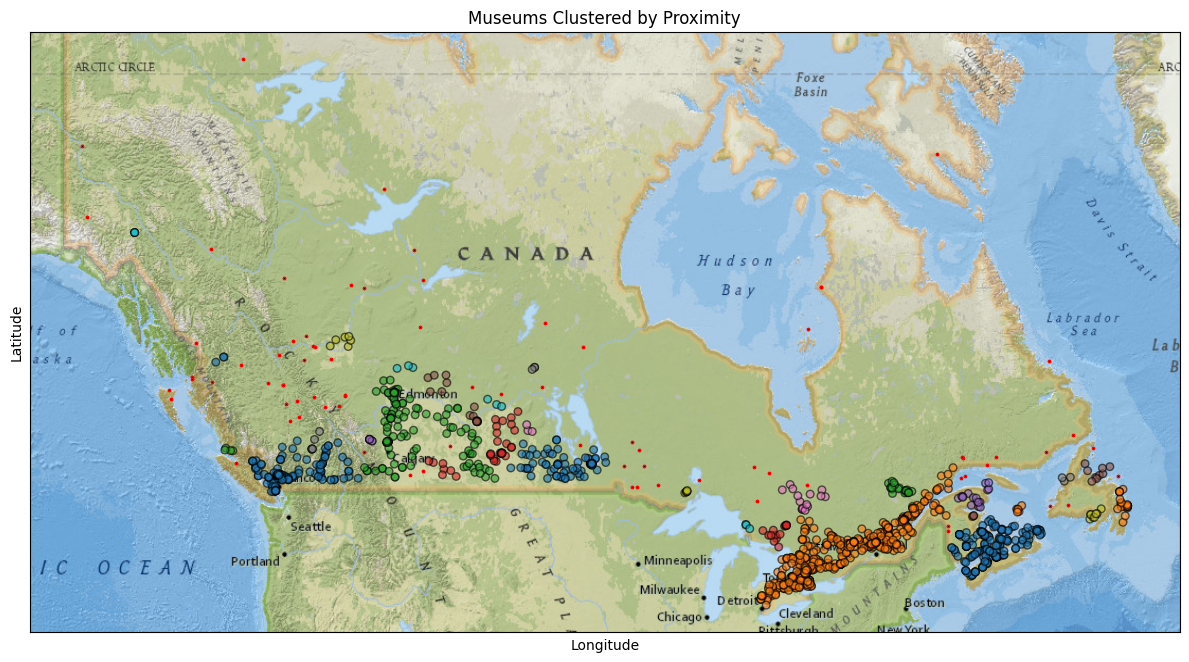

In [36]:
plot_clustered_locations(df_museum, title='Museums Clustered by Proximity')

#### HDBSCAN and Visualization

In [40]:
hdb = hdbscan.HDBSCAN(min_samples=None, min_cluster_size=5, metric='euclidean')
hdb.fit(df_model)

C:\Users\nanya\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\nanya\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN()

In [41]:
df_museum['Cluster'] = hdb.fit_predict(df_model)
df_museum['Cluster'].value_counts()

C:\Users\nanya\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\nanya\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\nanya\AppData\Local\Temp\ipykernel_20080\36209204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_museum['Cluster'] = hdb.fit_predict(df_model)


Cluster
-1     546
 49     89
 68     50
 56     46
 38     41
      ... 
 8       6
 5       6
 44      6
 11      5
 48      5
Name: count, Length: 70, dtype: int64

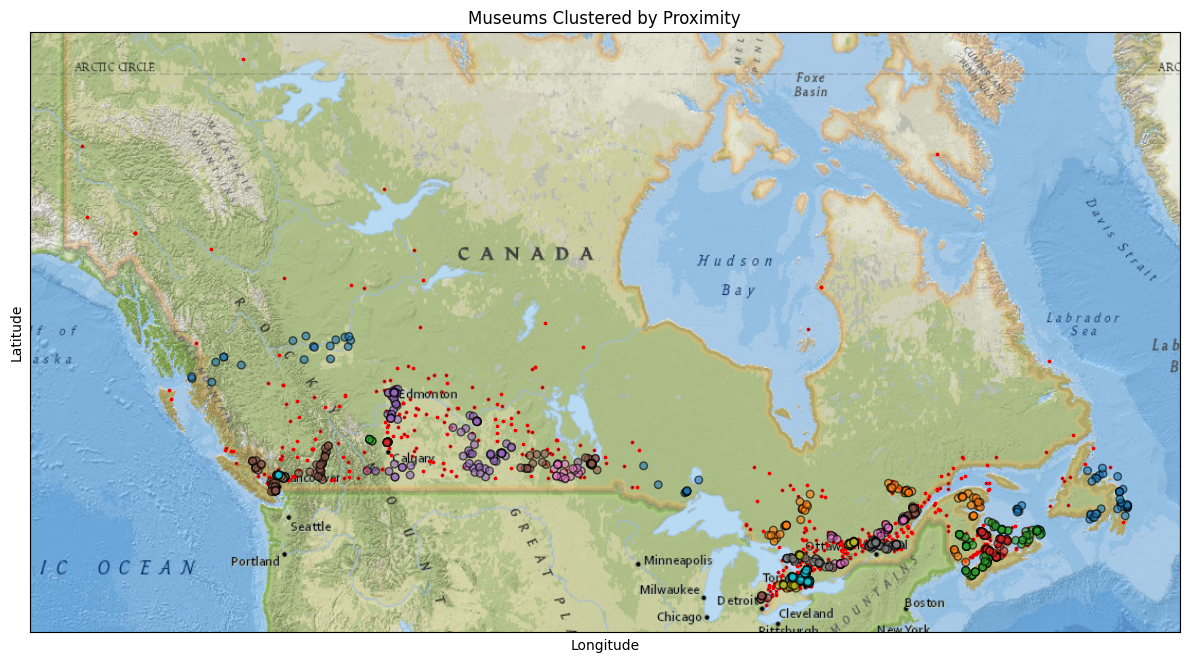

In [42]:
plot_clustered_locations(df_museum, title='Museums Clustered by Proximity')